In [ ]:
%pip install --upgrade tensorflow keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 572.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.3/381.3 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow
  

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import kagglehub
import os
import json

def create_improved_model(input_shape, num_classes):
    """
    Create an improved model using EfficientNetB0 as backbone with custom top layers
    """
    # Load pre-trained EfficientNetB0 without top layers
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze early layers
    for layer in base_model.layers[:100]:
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    return model

def preprocess_image(img, img_size):
    """
    Enhanced image preprocessing pipeline
    """
    # Convert to RGB if needed
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
    elif img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Maintain aspect ratio while resizing
    h, w = img.shape[:2]
    scale = img_size / max(h, w)
    new_h, new_w = int(h * scale), int(w * scale)
    img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LANCZOS4)

    # Create square image with padding
    square_img = np.zeros((img_size, img_size, 3), dtype=np.uint8)
    y_offset = (img_size - new_h) // 2
    x_offset = (img_size - new_w) // 2
    square_img[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = img

    # Enhance contrast
    lab = cv2.cvtColor(square_img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l_clahe = clahe.apply(l)
    lab = cv2.merge([l_clahe, a, b])
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    # Normalize using EfficientNet preprocessing
    img = tf.keras.applications.efficientnet.preprocess_input(img)

    return img

def generate_augmented_images(image, num_augmented=5):
    """
    Generate augmented images with more controlled transformations
    """
    augmenter = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='constant',
        cval=0
    )

    image = np.expand_dims(image, 0)
    augmented_images = []

    for _ in range(num_augmented):
        aug_image = next(augmenter.flow(image, batch_size=1))[0]
        augmented_images.append(aug_image)

    return augmented_images

def prepare_augmented_data():
    """
    Prepare dataset with improved preprocessing and balanced augmentation
    """
    path = kagglehub.dataset_download("myprojectdictionary/citrus-leaf-disease-image")
    categories = ['Black spot', 'Melanose', 'Canker', 'Greening', 'Healthy']
    image_dir = '/root/.cache/kagglehub/datasets/myprojectdictionary/citrus-leaf-disease-image/versions/1/Citrus Leaf Disease Image'

    data = []
    labels = []
    img_size = 224  # EfficientNetB0 default input size

    print("Starting enhanced data preparation...")

    # First pass: count samples per class
    class_counts = {}
    for category in categories:
        class_counts[category] = len(os.listdir(os.path.join(image_dir, category)))

    # Calculate target count (for balancing)
    max_samples = max(class_counts.values())

    for category in categories:
        category_path = os.path.join(image_dir, category)
        class_label = categories.index(category)
        print(f"\nProcessing category: {category}")

        files = os.listdir(category_path)
        current_count = len(files)
        augmentation_factor = max(1, int(max_samples / current_count))

        for img_name in files:
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)

            if img is not None:
                # Apply enhanced preprocessing
                processed_img = preprocess_image(img, img_size)
                data.append(processed_img)
                labels.append(class_label)

                # Generate augmented images for balancing
                if current_count < max_samples:
                    augmented = generate_augmented_images(
                        processed_img,
                        num_augmented=min(5, augmentation_factor - 1)
                    )
                    data.extend(augmented)
                    labels.extend([class_label] * len(augmented))

    data = np.array(data)
    labels = np.array(labels)

    print("\nClass distribution after balancing:")
    unique, counts = np.unique(labels, return_counts=True)
    for cat, count in zip(categories, counts):
        print(f"{cat}: {count} images")

    # Convert labels to categorical
    labels = tf.keras.utils.to_categorical(labels, len(categories))

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        data, labels, test_size=0.15, random_state=42,
        stratify=np.argmax(labels, axis=1)
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.15, random_state=42,
        stratify=np.argmax(y_train, axis=1)
    )

    return X_train, X_val, X_test, y_train, y_val, y_test, categories

def save_model_h5(model, categories, filename="citrus_disease_model.h5"):
    """
    Save model in H5 format along with metadata
    """
    # Save the model in H5 format
    model.save(filename, save_format='tf')

    # Save additional metadata separately
    metadata = {
        'categories': categories,
        'input_shape': [224, 224, 3],
        'preprocessing_info': {
            'mean': 0.0,
            'std': 1.0,
            'rescale': 1/255
        }
    }

    # Save metadata to JSON file
    metadata_filename = filename.replace('.h5', '_metadata.json')
    with open(metadata_filename, 'w') as f:
        json.dump(metadata, f, indent=4)

    print(f"\nModel saved in H5 format as: {filename}")
    print(f"Model metadata saved as: {metadata_filename}")

def main():
    print("Preparing data with enhanced preprocessing...")
    X_train, X_val, X_test, y_train, y_val, y_test, categories = prepare_augmented_data()

    print("\nCreating improved model...")
    model = create_improved_model(input_shape=(224, 224, 3), num_classes=len(categories))

    # Use a lower learning rate for transfer learning
    optimizer = Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    # Enhanced training data generator
    train_datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='constant',
        cval=0
    )

    # Create data generator
    train_generator = train_datagen.flow(
        X_train, y_train,
        batch_size=16
    )

    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            min_delta=1e-4
        ),
        ModelCheckpoint(
            "best_model.keras",
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
    ]

    print("\nStarting training...")
    # Updated fit call without workers and use_multiprocessing
    history = model.fit(
        train_generator,
        epochs=50,
        validation_data=(X_val, y_val),
        callbacks=callbacks
    )

    # Evaluate model
    print("\nEvaluating model...")
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test)
    print(f"\nTest Metrics:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")

    # Generate detailed classification report
    y_pred = model.predict(X_test)
    print("\nDetailed Classification Report:")
    print(classification_report(
        np.argmax(y_test, axis=1),
        np.argmax(y_pred, axis=1),
        target_names=categories,
        digits=4
    ))

    # Save the model
    model.save("final_model.keras")
    save_model_h5(model, categories)
    print("\nModel saved successfully!")

if __name__ == "__main__":
    main()

Preparing data with enhanced preprocessing...


100%|██████████| 41.3M/41.3M [00:00<00:00, 145MB/s]

Extracting files...


Starting enhanced data preparation...

Processing category: Black spot

Processing category: Melanose

Processing category: Canker

Processing category: Greening

Processing category: Healthy

Class distribution after balancing:
Black spot: 169 images
Melanose: 78 images
Canker: 163 images
Greening: 204 images
Healthy: 174 images

Creating improved model...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Starting training...


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 44s 531ms/step - accuracy: 0.2460 - loss: 2.0653 - precision: 0.2942 - recall: 0.1375 - val_accuracy: 0.4455 - val_loss: 1.3801 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 420ms/step - accuracy: 0.4683 - loss: 1.2730 - precision: 0.5878 - recall: 0.3179 - val_accuracy: 0.6337 - val_loss: 1.0640 - val_precision: 0.9231 - val_recall: 0.1188 - learning_rate: 1.0000e-04
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 421ms/step - accuracy: 0.7053 - loss: 0.8126 - precision: 0.7990 - recall: 0.5919 - val_accuracy: 0.7822 - val_loss: 0.7539 - val_precision: 0.8421 - val_recall: 0.4752 - learning_rate: 1.0000e-04
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 418ms/step - accuracy: 0.7884 - loss: 0.5842 - precision: 0.8640 - recall: 0.7365 - val_accuracy: 0.8317 - val_loss: 0.5112 - val_precision: 0.8537 - val_recall: 0.6931 - learning_rate: 1.0000e-04
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━


Model saved in H5 format as: citrus_disease_model.h5
Model metadata saved as: citrus_disease_model_metadata.json

Model saved successfully!


Initializing predictor...

Options:
1. Predict random images from all categories
2. Predict images from specific category
3. Exit

Enter your choice (1-3): 1
How many images per category? 1


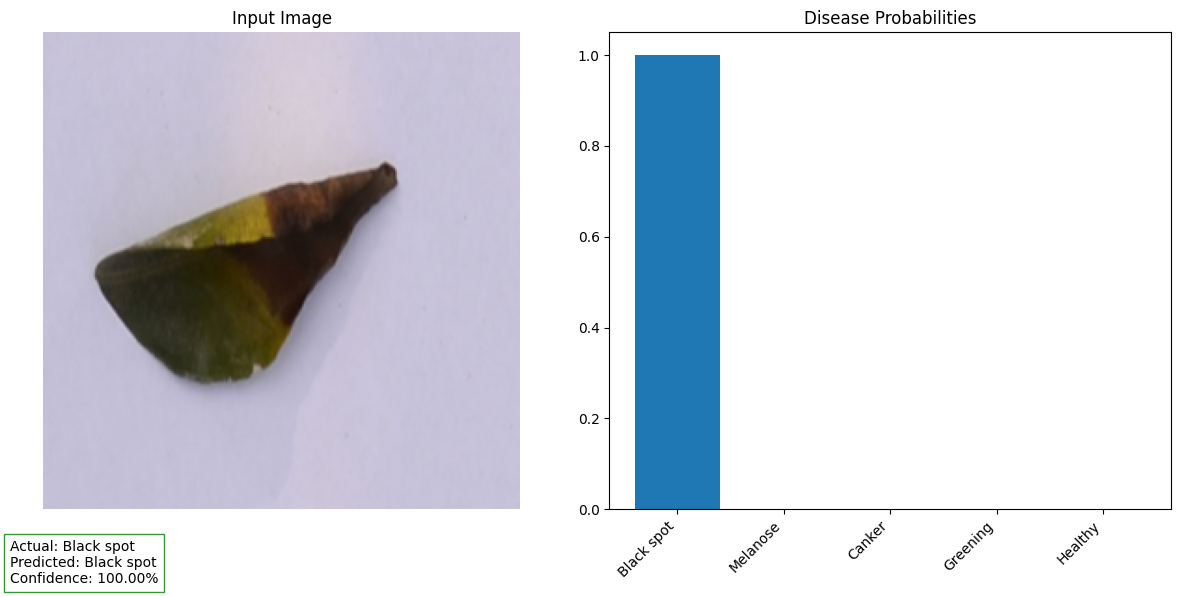

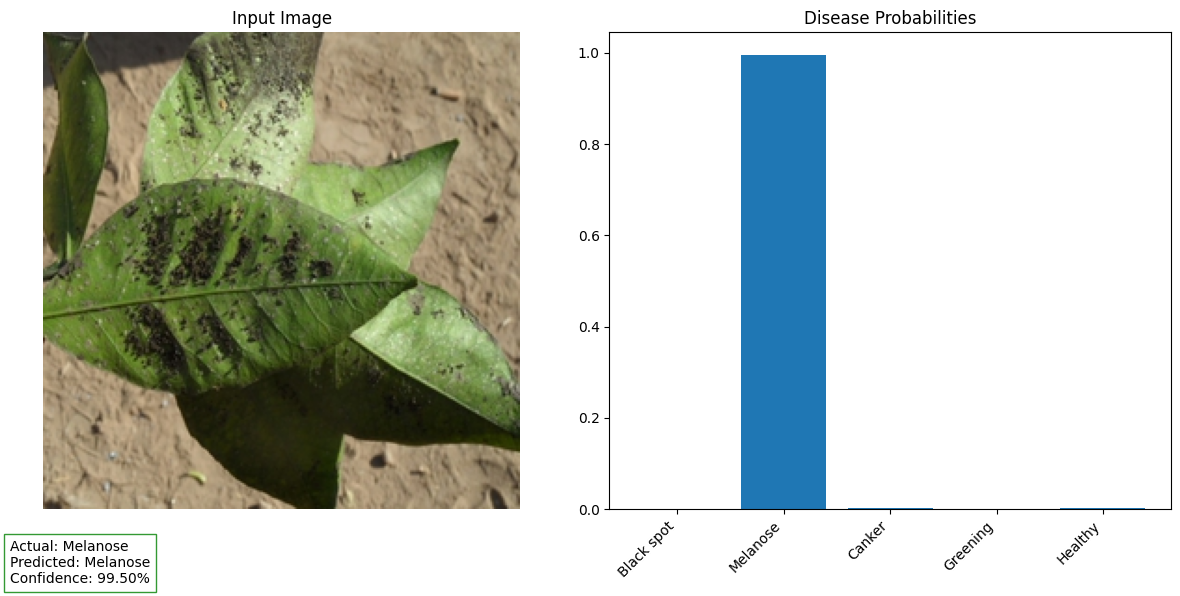

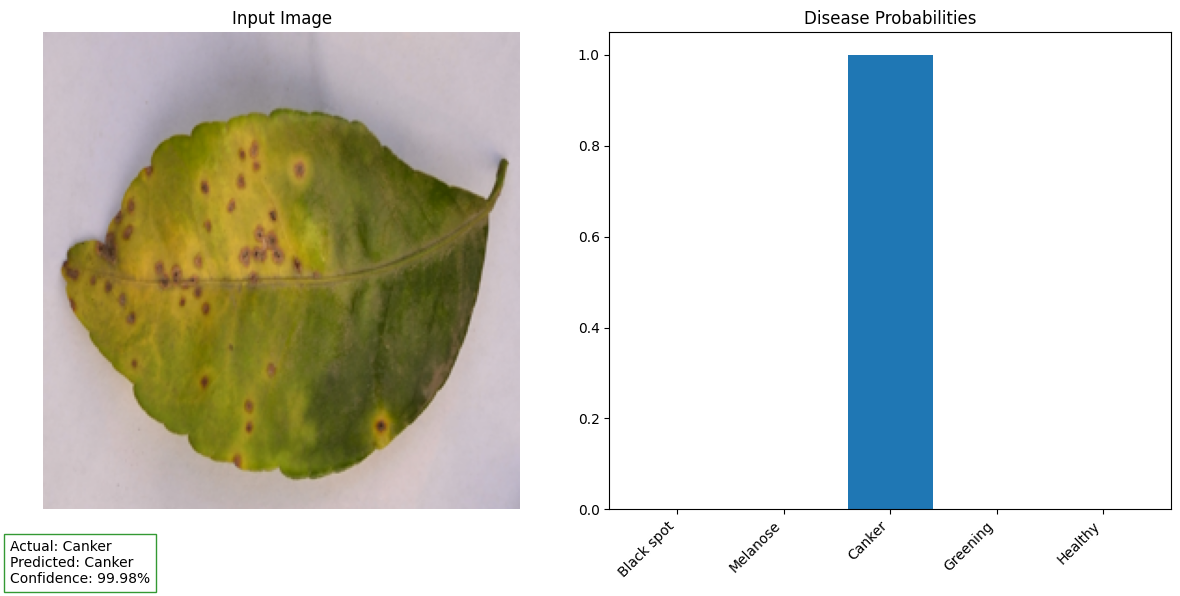

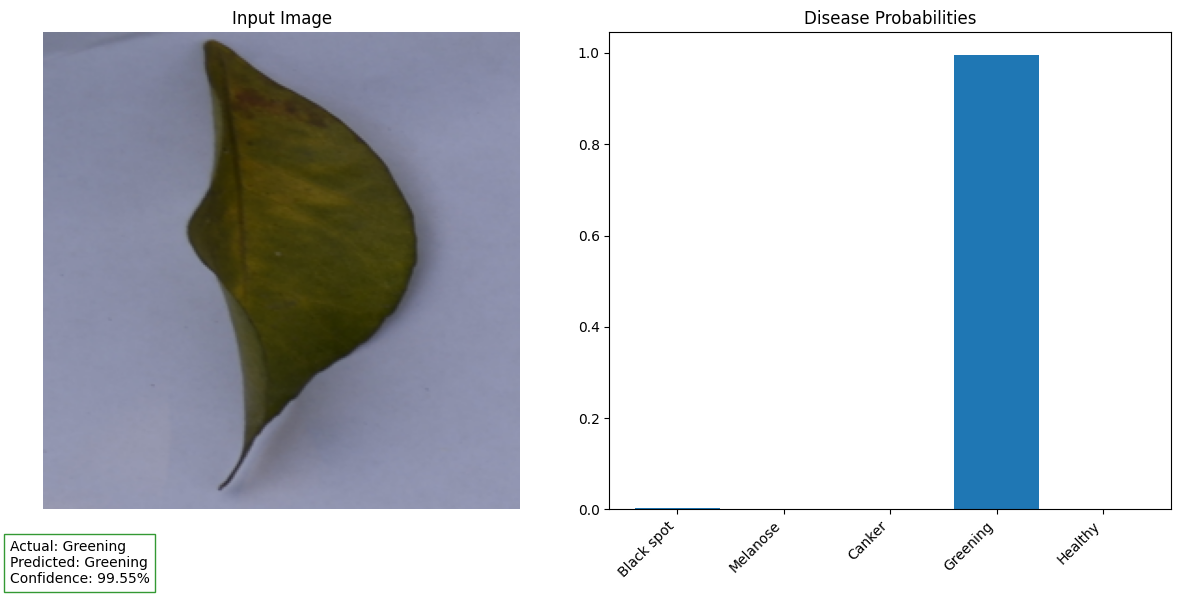

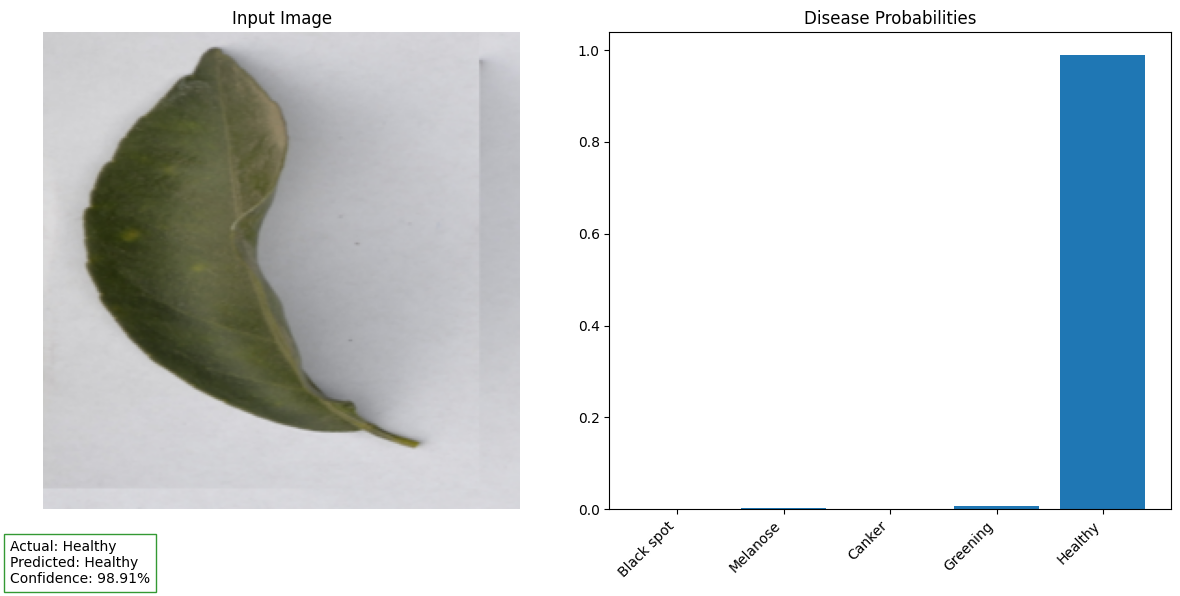


Options:
1. Predict random images from all categories
2. Predict images from specific category
3. Exit

Enter your choice (1-3): 3
Exiting...


In [3]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import kagglehub

class CitrusDiseasePredictor:
    def __init__(self, model_path="final_model.keras"):
        """
        Initialize the predictor with a trained model
        """
        self.model = tf.keras.models.load_model(model_path)
        self.img_size = 224  # EfficientNetB0 input size
        self.categories = ['Black spot', 'Melanose', 'Canker', 'Greening', 'Healthy']

        # Download and set dataset path
        kagglehub.dataset_download("myprojectdictionary/citrus-leaf-disease-image")
        self.dataset_path = '/root/.cache/kagglehub/datasets/myprojectdictionary/citrus-leaf-disease-image/versions/1/Citrus Leaf Disease Image'

    def preprocess_image(self, img):
        """
        Preprocess image for prediction
        """
        # Convert to RGB if needed
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
        elif img.shape[2] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Maintain aspect ratio while resizing
        h, w = img.shape[:2]
        scale = self.img_size / max(h, w)
        new_h, new_w = int(h * scale), int(w * scale)
        img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LANCZOS4)

        # Create square image with padding
        square_img = np.zeros((self.img_size, self.img_size, 3), dtype=np.uint8)
        y_offset = (self.img_size - new_h) // 2
        x_offset = (self.img_size - new_w) // 2
        square_img[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = img

        # Enhance contrast
        lab = cv2.cvtColor(square_img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        l_clahe = clahe.apply(l)
        lab = cv2.merge([l_clahe, a, b])
        img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

        # Normalize using EfficientNet preprocessing
        img = tf.keras.applications.efficientnet.preprocess_input(img)
        return img

    def predict_random_images(self, num_images=5):
        """
        Predict random images from each category in the dataset
        """
        results = []

        # Get random images from each category
        for category in self.categories:
            category_path = os.path.join(self.dataset_path, category)
            images = os.listdir(category_path)

            # Select random images from this category
            selected_images = random.sample(images, min(num_images, len(images)))

            for img_name in selected_images:
                img_path = os.path.join(category_path, img_name)
                try:
                    # Read and preprocess image
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"Could not read image: {img_path}")
                        continue

                    processed_img = self.preprocess_image(img)
                    processed_img = np.expand_dims(processed_img, axis=0)

                    # Make prediction
                    predictions = self.model.predict(processed_img, verbose=0)
                    predicted_class = np.argmax(predictions[0])
                    confidence = predictions[0][predicted_class]

                    result = {
                        'image_path': img_path,
                        'actual_class': category,
                        'predicted_class': self.categories[predicted_class],
                        'confidence': confidence,
                        'all_probabilities': dict(zip(self.categories, predictions[0])),
                        'image': img
                    }
                    results.append(result)

                    # Display results
                    self._display_prediction(result)

                except Exception as e:
                    print(f"Error processing {img_path}: {str(e)}")

        return results

    def predict_specific_category(self, category, num_images=5):
        """
        Predict specific number of images from a given category
        """
        if category not in self.categories:
            raise ValueError(f"Category must be one of {self.categories}")

        category_path = os.path.join(self.dataset_path, category)
        images = os.listdir(category_path)
        selected_images = random.sample(images, min(num_images, len(images)))

        results = []
        for img_name in selected_images:
            img_path = os.path.join(category_path, img_name)
            try:
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Could not read image: {img_path}")
                    continue

                processed_img = self.preprocess_image(img)
                processed_img = np.expand_dims(processed_img, axis=0)

                predictions = self.model.predict(processed_img, verbose=0)
                predicted_class = np.argmax(predictions[0])
                confidence = predictions[0][predicted_class]

                result = {
                    'image_path': img_path,
                    'actual_class': category,
                    'predicted_class': self.categories[predicted_class],
                    'confidence': confidence,
                    'all_probabilities': dict(zip(self.categories, predictions[0])),
                    'image': img
                }
                results.append(result)

                # Display results
                self._display_prediction(result)

            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")

        return results

    def _display_prediction(self, result):
        """
        Display the image with prediction results
        """
        plt.figure(figsize=(12, 6))

        # Display image
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(result['image'], cv2.COLOR_BGR2RGB))
        plt.title('Input Image')
        plt.axis('off')

        # Display prediction probabilities
        plt.subplot(1, 2, 2)
        probabilities = list(result['all_probabilities'].values())
        plt.bar(self.categories, probabilities)
        plt.xticks(rotation=45, ha='right')
        plt.title('Disease Probabilities')
        plt.tight_layout()

        # Add prediction text
        prediction_correct = result['actual_class'] == result['predicted_class']
        color = 'green' if prediction_correct else 'red'

        plt.figtext(
            0.02, 0.02,
            f"Actual: {result['actual_class']}\n" +
            f"Predicted: {result['predicted_class']}\n" +
            f"Confidence: {result['confidence']*100:.2f}%",
            bbox=dict(facecolor='white', alpha=0.8, edgecolor=color)
        )

        plt.show()

def main():
    print("Initializing predictor...")
    predictor = CitrusDiseasePredictor("final_model.keras")

    while True:
        print("\nOptions:")
        print("1. Predict random images from all categories")
        print("2. Predict images from specific category")
        print("3. Exit")

        choice = input("\nEnter your choice (1-3): ")

        if choice == '1':
            num_images = int(input("How many images per category? "))
            predictor.predict_random_images(num_images)

        elif choice == '2':
            print("\nAvailable categories:")
            for i, category in enumerate(predictor.categories, 1):
                print(f"{i}. {category}")

            cat_choice = int(input("\nEnter category number: ")) - 1
            if 0 <= cat_choice < len(predictor.categories):
                num_images = int(input("How many images? "))
                predictor.predict_specific_category(predictor.categories[cat_choice], num_images)
            else:
                print("Invalid category number!")

        elif choice == '3':
            print("Exiting...")
            break

        else:
            print("Invalid choice! Please try again.")

if __name__ == "__main__":
    main()

In [4]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
import keras
print("Standalone Keras version:", keras.__version__)



TensorFlow version: 2.18.0
Standalone Keras version: 3.6.0
